In [1]:
import os
%pwd

'd:\\ML-Projects\\03-Air-Quality-Index-Predictor\\research'

In [2]:
os.chdir("../")
%pwd

'd:\\ML-Projects\\03-Air-Quality-Index-Predictor'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product


d:\ML-Projects\03-Air-Quality-Index-Predictor\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_data = pd.read_csv(r"artifacts\data_transformation\train_dataset.csv", parse_dates=['date'])
test_data = pd.read_csv(r"artifacts\data_transformation\test_dataset.csv", parse_dates=['date'])


In [61]:
def plot_forecasts(train, test, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train.values, label='Train')
    plt.plot(test.index, test.values, label='Test')
    plt.plot(test.index, predictions, label='Predictions', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

def evaluate_forecast(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

def city_forecasting_with_plot(city, train, test, model_func, plot=True, **kwargs):
    train_city = train[train['city'] == city]
    test_city = test[test['city'] == city]
    
    train_city.set_index('date', inplace=True)
    test_city.set_index('date', inplace=True)
    
    # Set the frequency explicitly to weekly ('W')
    train_city = train_city.asfreq('W')
    test_city = test_city.asfreq('W')
    
    train_series = pd.Series(train_city['AQI_calculated'])
    test_series = pd.Series(test_city['AQI_calculated'])
    
    forecast = model_func(train_series, test_series, **kwargs)
    if forecast is None:
        print(f"Warning: Forecast for AQI_calculated is None")
        return {}, {}
    
    forecasts = {'AQI_calculated': forecast}
    
    try:
        rmse, mae = evaluate_forecast(test_series, forecast)
        metrics = {'AQI_calculated': {'RMSE': rmse, 'MAE': mae}}
    except Exception as e:
        print(f"Error in evaluating forecast for AQI_calculated: {e}")
        return {}, {}
    
    if plot:
        plot_forecasts(train_series, test_series, forecast, title=f'{city} - AQI_calculated')
    
    return forecasts, metrics


## 1. Exponential Smoothing

In [6]:
# Exponential Smoothing (ETS)
def ets_forecast(train, test, seasonal='add', seasonal_periods=12):
    model = ExponentialSmoothing(train, trend='add', seasonal=seasonal, seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

Forecasting for Delhi using Exponential Smoothing (ETS)


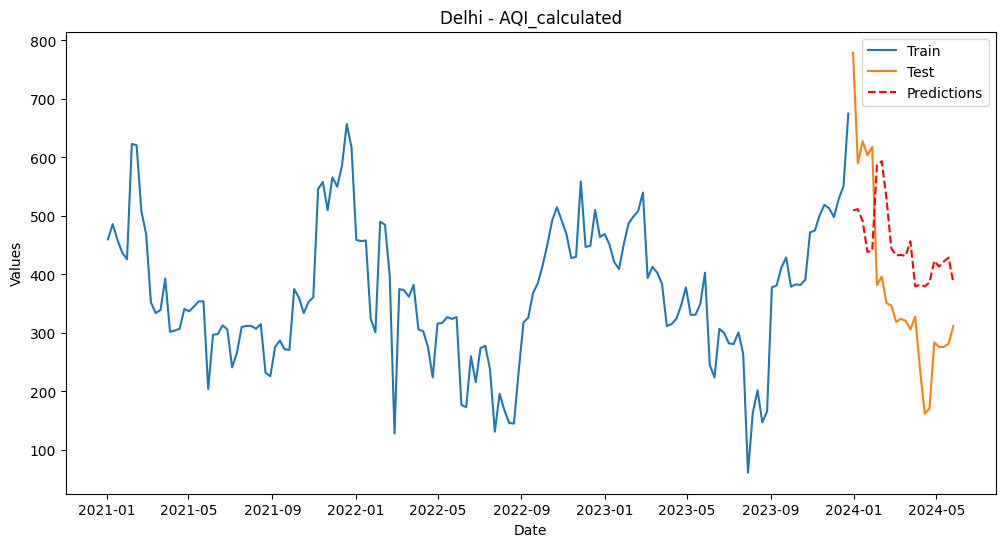

ETS Metrics: {'AQI_calculated': {'RMSE': 156.98745562961327, 'MAE': 148.2681996805262}}


In [7]:

# City to forecast
city_name = 'Delhi'

# Exponential Smoothing (ETS) Forecast
print(f"Forecasting for {city_name} using Exponential Smoothing (ETS)")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, ets_forecast, seasonal='add', seasonal_periods=52)
print("ETS Metrics:", ets_metrics)




### Improved

In [8]:
def ets_forecast_updated(train, test):
    param_grid = {
        'trend': ['add', 'mul', None],
        'seasonal': ['add', 'mul', None],
        'seasonal_periods': [12, 52]  # Adjust as needed
    }
    
    best_score = float('inf')
    best_params = None
    best_forecast = None
    
    # Check if train data is strictly positive
    is_positive = np.all(train > 0)
    
    for trend, seasonal, seasonal_periods in product(param_grid['trend'], param_grid['seasonal'], param_grid['seasonal_periods']):
        if not is_positive and (trend == 'mul' or seasonal == 'mul'):
            print(f"Skipping combination trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods} due to non-positive values in the data")
            continue
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                
                # Clipping the train data to avoid extreme values causing overflow
                clipped_train = train.clip(lower=-1e10, upper=1e10)
                
                model = ExponentialSmoothing(clipped_train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test))
                score = mean_squared_error(test, forecast)
                
                if score < best_score:
                    best_score = score
                    best_params = {'trend': trend, 'seasonal': seasonal, 'seasonal_periods': seasonal_periods}
                    best_forecast = forecast
        except Exception as e:
            print(f"Error fitting model with trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods}: {e}")
            continue
    
    print(f"Best Parameters: {best_params}")
    return best_forecast


Forecasting for Delhi using Exponential Smoothing (ETS)
Best Parameters: {'trend': None, 'seasonal': 'add', 'seasonal_periods': 52}


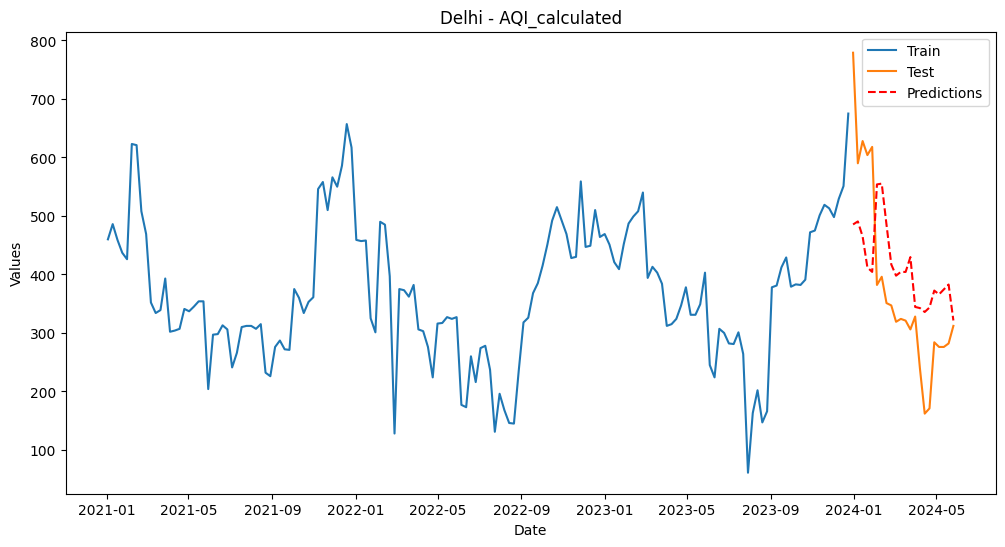

ETS Metrics: {'AQI_calculated': {'RMSE': 138.93499187324008, 'MAE': 123.45766815427235}}


In [9]:

# City to forecast
city_name = 'Delhi'

# Exponential Smoothing (ETS) Forecast
print(f"Forecasting for {city_name} using Exponential Smoothing (ETS)")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, ets_forecast_updated)
print("ETS Metrics:", ets_metrics)


## 2. Arima

In [63]:
# ARIMA
def arima_forecast(train, test, order=(5,1,0)):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

Forecasting for Delhi using ARIMA


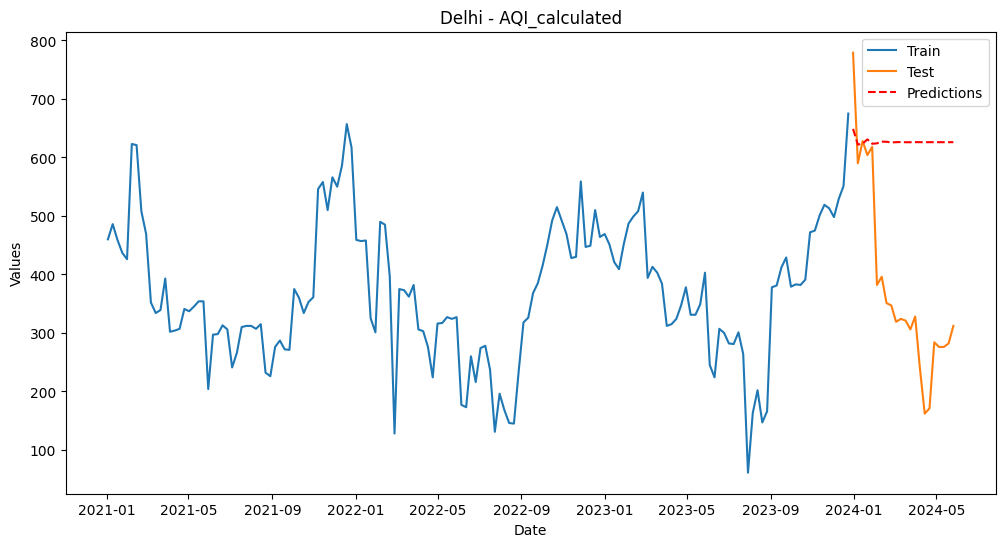

ETS Metrics: {'AQI_calculated': {'RMSE': 294.3157035785221, 'MAE': 262.05673808308387}}


In [64]:
# City to forecast
city_name = 'Delhi'

# Exponential Smoothing (ETS) Forecast
print(f"Forecasting for {city_name} using ARIMA")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, arima_forecast)
print("ETS Metrics:", ets_metrics)

### Improved

In [12]:
def arima_forecast_updated(train, test):
    p = range(0, 6)
    d = range(0, 3)
    q = range(0, 6)
    pdq = list(product(p, d, q))

    best_score = float('inf')
    best_params = None
    best_forecast = None

    for params in pdq:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = ARIMA(train, order=params)
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test))
                score = mean_squared_error(test, forecast)
                
                if score < best_score:
                    best_score = score
                    best_params = params
                    best_forecast = forecast
        except Exception as e:
            continue

    print(f"Best Parameters: {best_params}")
    return best_forecast

Forecasting for Delhi using Exponential Smoothing (ETS)
Best Parameters: (3, 0, 4)


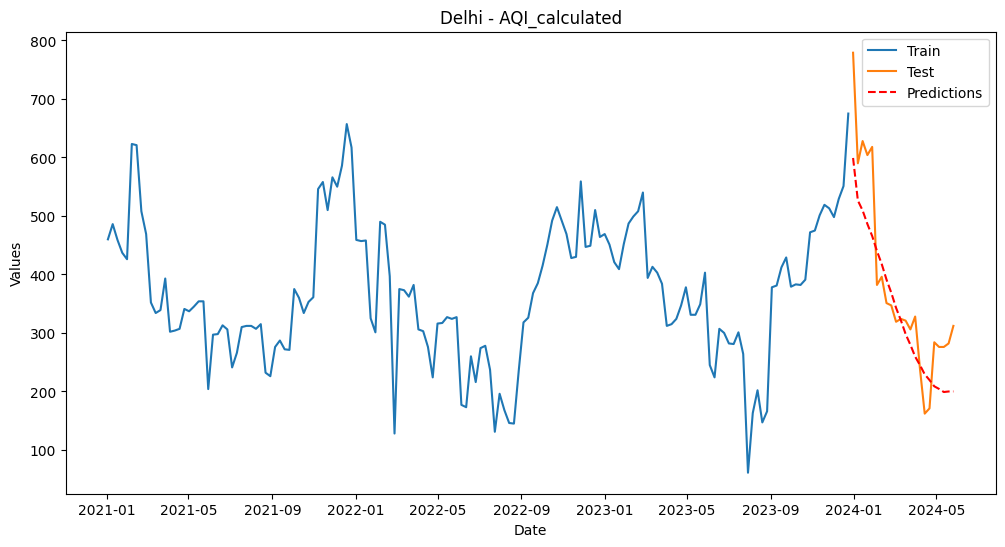

ETS Metrics: {'AQI_calculated': {'RMSE': 80.612035808917, 'MAE': 66.26149842073212}}


In [13]:

# Exponential Smoothing (ETS) Forecast
print(f"Forecasting for {city_name} using ARIMA")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, arima_forecast_updated)
print("ETS Metrics:", ets_metrics)

## 3. SARIMA

In [24]:

def sarima_forecast(train, test, order=(1,1,1), seasonal_order=(1,1,1,12)):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test))
    return forecast


Forecasting for Delhi using SARIMA


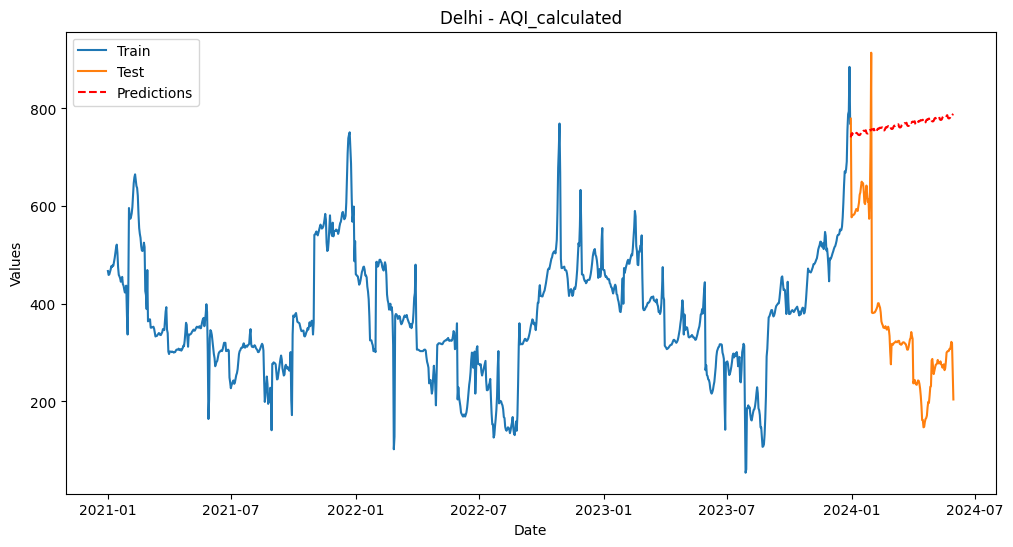

ETS Metrics: {'AQI_calculated': {'RMSE': 433.0533693686776, 'MAE': 406.1183153521099}}


In [25]:

print(f"Forecasting for {city_name} using SARIMA")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, sarima_forecast)
print("ETS Metrics:", ets_metrics)

In [31]:
def sarima_forecast_updated(train, test, order=(1,0,0), seasonal_order=(2,0,0,52)):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test))
    return forecast

Forecasting for Delhi using SARIMA


d:\ML-Projects\03-Air-Quality-Index-Predictor\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


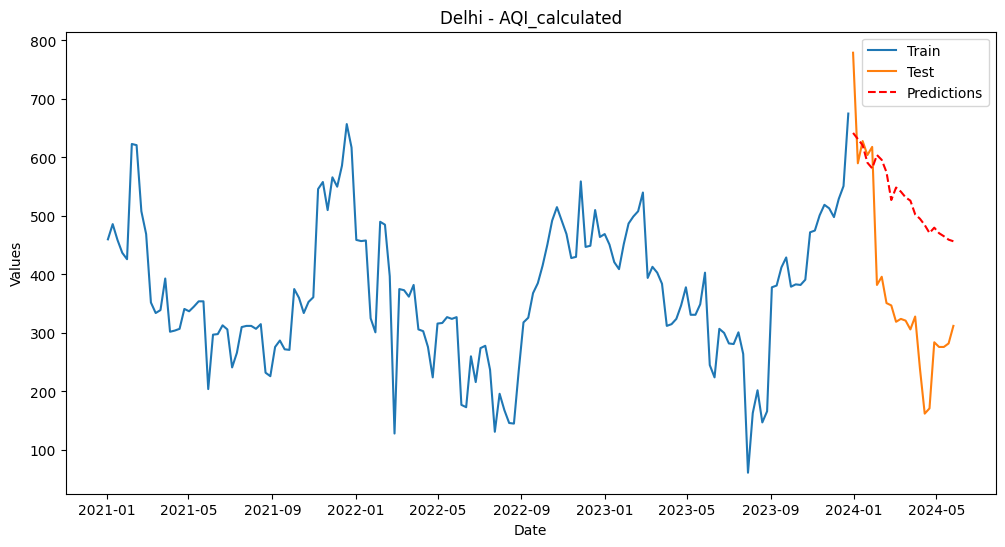

ETS Metrics: {'AQI_calculated': {'RMSE': 195.53493653595652, 'MAE': 176.99308344523286}}


In [33]:

print(f"Forecasting for {city_name} using SARIMA")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, sarima_forecast_updated)
print("ETS Metrics:", ets_metrics)

## 4. Prophet


In [35]:
def prophet_forecast(train, test):
    df = train.reset_index()
    df.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    return forecast['yhat'][-len(test):].values

14:43:59 - cmdstanpy - INFO - Chain [1] start processing


Forecasting for Delhi using Prophet


14:44:00 - cmdstanpy - INFO - Chain [1] done processing


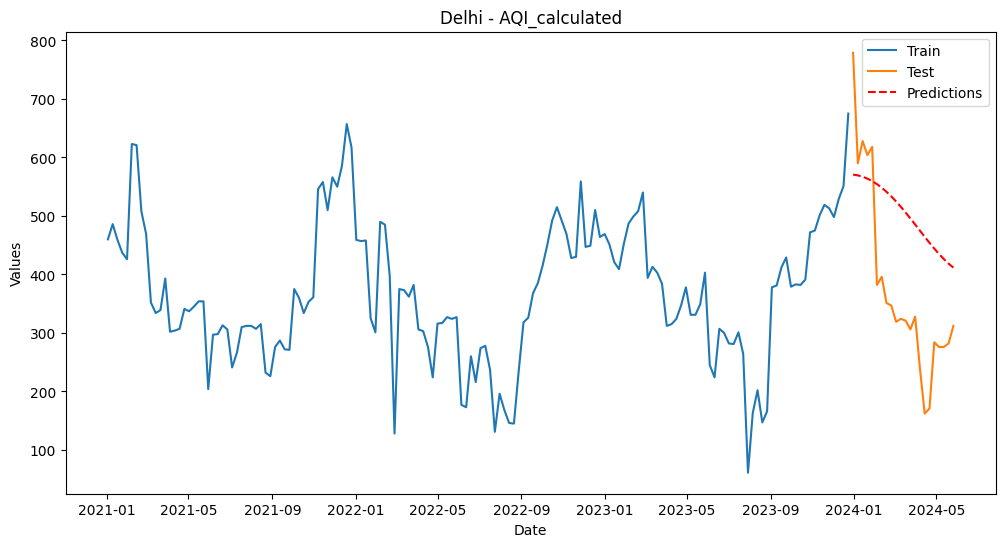

ETS Metrics: {'AQI_calculated': {'RMSE': 175.74384615595628, 'MAE': 161.17322887608947}}


In [36]:
print(f"Forecasting for {city_name} using Prophet")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, prophet_forecast)
print("ETS Metrics:", ets_metrics)

### Improved

In [43]:


from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import numpy as np

def prophet_forecast_tuned(train, test):
    df_train = train.reset_index()
    df_train.columns = ['ds', 'y']
    df_test = test.reset_index()
    df_test.columns = ['ds', 'y']

    param_grid = {
        'changepoint_prior_scale': [0.05, 0.1, 0.5],
        'seasonality_prior_scale': [5, 10, 20],
        'n_changepoints': [10, 20, 30],
        'daily_seasonality': [True, False]
    }
    
    best_model = None
    best_mse = float('inf')  # Initialize with a high value

    for params in ParameterGrid(param_grid):
        model = Prophet(**params)
        model.fit(df_train)
        
        forecast = model.predict(df_test)
        mse = mean_squared_error(df_test['y'], forecast['yhat'])
        
        if mse < best_mse:
            best_mse = mse
            best_model = model

    future = best_model.make_future_dataframe(periods=len(df_test))
    forecast = best_model.predict(future)
    return forecast['yhat'][-len(df_test):].values


14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Delhi using Prophet


14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1]

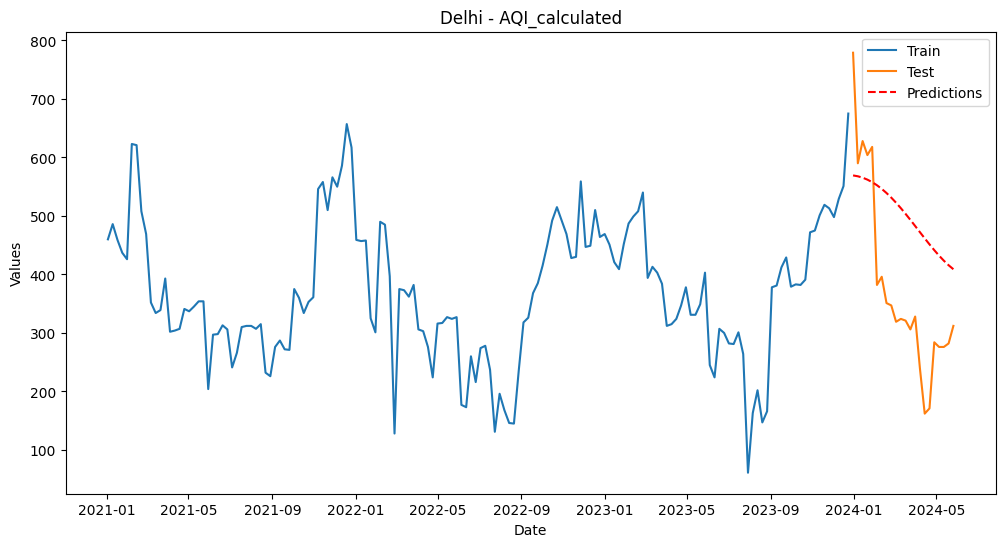

ETS Metrics: {'AQI_calculated': {'RMSE': 173.90187730380106, 'MAE': 159.6433410022417}}


In [45]:
print(f"Forecasting for {city_name} using Prophet")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, prophet_forecast_tuned)
print("ETS Metrics:", ets_metrics)

## 5. Auto Arima

In [51]:
from pmdarima import auto_arima


def auto_arima_forecast(train, test, seasonal=True, m=12):

    # Concatenate train and test data for fitting
    df = pd.concat([train, test], axis=0)

    # Fit auto ARIMA
    model = auto_arima(df, seasonal=seasonal, m=m)

    # Summary of the best model
    print("Auto ARIMA Model Summary:")
    print(model.summary())

    # Forecast
    forecast = model.predict(n_periods=len(test))
    return forecast



Forecasting for Delhi using Auto Arima
Auto ARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  178
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -999.988
Date:                            Wed, 05 Jun 2024   AIC                           2009.977
Time:                                    15:05:54   BIC                           2025.886
Sample:                                01-03-2021   HQIC                          2016.428
                                     - 05-26-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     89.7580     18.907      4.747      

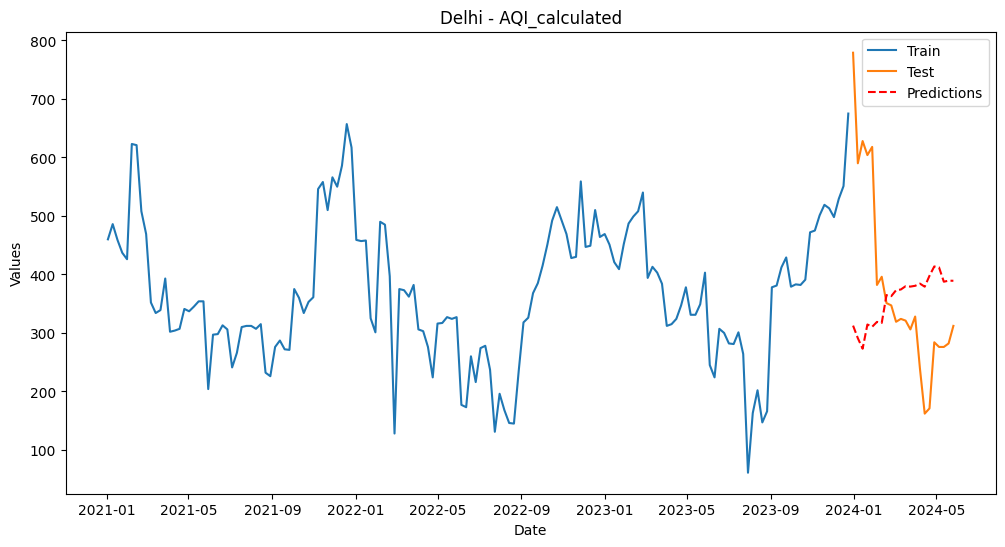

ETS Metrics: {'AQI_calculated': {'RMSE': 193.53063216328684, 'MAE': 151.30738985248374}}


In [52]:
print(f"Forecasting for {city_name} using Auto Arima")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, auto_arima_forecast)
print("ETS Metrics:", ets_metrics)